<a href="https://colab.research.google.com/github/andradec/ReconhecimentoFacial/blob/main/ReconhecimentoFacial_IAGenerativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"caandrad","key":"0d71cd53f903852343844e0233a3ef2a"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d sbaghbidi/human-faces-object-detection

100% 498M/498M [00:23<00:00, 22.3MB/s]
100% 498M/498M [00:23<00:00, 22.0MB/s]


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!unzip human-faces-object-detection.zip

In [ ]:
import os
import cv2 as cv
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions


In [ ]:
df = pd.read_csv('/content/faces.csv')

In [ ]:
df.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [ ]:
data = {}                                          # the image will be resized to 128x128 so here we are extracting the bbox coordinates
for i in df["image_name"]:                         # and we are rescaling it to 128x128 images
  if i not in data:
    data[i] = []
for idx, img_name in enumerate(df["image_name"]):
      width = df["width"][idx]
      height = df["height"][idx]
      x1 = df["x0"][idx]
      y1 = df["y0"][idx]
      x2 = df["x1"][idx]
      y2 = df["y1"][idx]

      new_x1 = int((x1/width)*128)
      new_y1 = int((y1/height)*128)
      new_x2 = int((x2/width)*128)
      new_y2 = int((y2/height)*128)

      data[img_name].append(new_x1)
      data[img_name].append(new_y1)
      data[img_name].append(new_x2)
      data[img_name].append(new_y2)

In [ ]:
print(df)

        image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]


In [ ]:
img_dir = os.listdir('/content/images')        # reading the images
images = []
for img_name in data.keys():
    for itr in img_dir:
      if img_name==itr:
        img_arr = cv.imread(os.path.join('/content/images', img_name), cv.IMREAD_GRAYSCALE)
        resized_img = cv.resize(img_arr, (128, 128))
        images.append(resized_img)
        print(images)

In [21]:
bbox = []               # extracting the bboxs from the data dictionary
for boxes in data.keys():
  bbox.append(data[boxes])

In [22]:
images = np.array(images)

In [23]:
images = np.expand_dims(images, axis=3)

In [24]:
print(f"shape of images {images.shape}")

shape of images (2204, 128, 128, 1)


In [25]:
max_bbox = 0          # getting the maximum number of bounding boxes from the images
for i in range(len(bbox)):
  max_bbox = max(max_bbox, len(bbox[i]))
print(f"the max faces in the image are {int(max_bbox/4)}")

the max faces in the image are 12


In [26]:
for i in range(len(bbox)):     #padding the bbox with 0's to make shape of all bbox equal
  if int(max_bbox) - len(bbox[i])!=0:
    for j in range(int(max_bbox) - len(bbox[i])):
      bbox[i].append(0)

In [27]:
bbox = np.array(bbox)

In [28]:
print(f"shape of bbox {bbox.shape}")

shape of bbox (2204, 48)


In [29]:
images = images/255   # normalizing the images and bbox
bbox = bbox/128

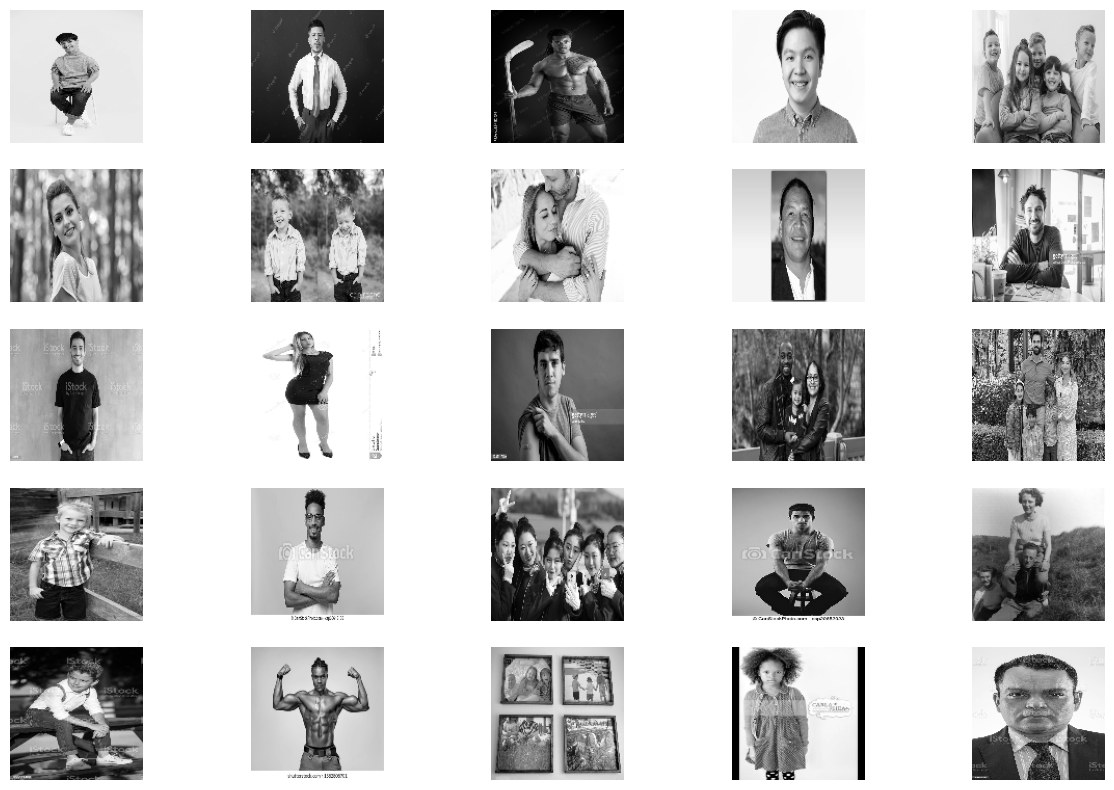

In [30]:
plt.figure(figsize=(15,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i], cmap='gray')
  plt.axis("off")

In [31]:
x_train, x_test, y_train, y_test = train_test_split(images, bbox, test_size=0.1, random_state=22)

In [32]:
model1 = Sequential()

model1.add(Conv2D(32, (3,3), input_shape=(128,128,1), padding="same", activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(64, (3,3), padding="same", activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(128, (3,3), padding="same", activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(256, (3,3), padding="same", activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256, activation="leaky_relu"))
model1.add(Dense(64, activation="leaky_relu"))
model1.add(Dense(48, activation="sigmoid"))

In [33]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [34]:
class CustomCallbacks(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    prediction = model1.predict(x_test[0].reshape(1, 128, 128, 1))
    fig, ax = plt.subplots(1)
    ax.imshow(x_test[0])
    x1 = int(prediction[0][0]*128)
    y1 = int(prediction[0][1]*128)
    x2 = int(prediction[0][2]*128)
    y2 = int(prediction[0][3]*128)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none")
    ax.add_patch(rect)
    plt.show()

In [35]:
model1.compile(optimizer = "adam", loss="binary_crossentropy")

In [ ]:
history1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=60, callbacks=[CustomCallbacks()])

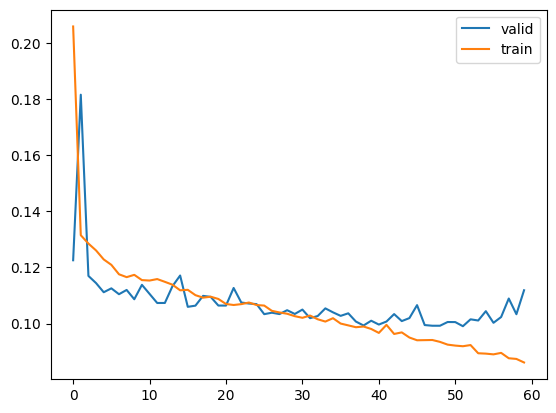

In [37]:
plt.plot(history1.history["val_loss"])
plt.plot(history1.history["loss"])
plt.legend(["valid", "train"])
plt.show()

In [38]:
y_pred = model1.predict(x_test)

7/7 [==============================] - 0s 9ms/step


In [39]:
print(f"mean absolute error is {mean_absolute_error(y_pred, y_test)}")

mean absolute error is 0.025792881208217783


In [40]:
model2 = Sequential()

model2.add(Conv2D(32, (3,3), input_shape=(128,128,1), activation="relu"))
model2.add(Dropout(0.1))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3,3), activation="relu"))
model2.add(Dropout(0.1))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3,3), activation="relu"))
model2.add(Dropout(0.2))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3,3), activation="relu"))
model2.add(Dropout(0.3))
model2.add(MaxPool2D(2,2))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation="leaky_relu"))
model2.add(Dense(48, activation="sigmoid"))

In [41]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)       

In [42]:
class CustomCallbacks2(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    prediction = model2.predict(x_test[0].reshape(1, 128, 128, 1))
    fig, ax = plt.subplots(1)
    ax.imshow(x_test[0])
    x1 = int(prediction[0][0]*128)
    y1 = int(prediction[0][1]*128)
    x2 = int(prediction[0][2]*128)
    y2 = int(prediction[0][3]*128)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none")
    ax.add_patch(rect)
    plt.show()

In [43]:
model2.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
history2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=8, epochs=100, callbacks=[CustomCallbacks2()])

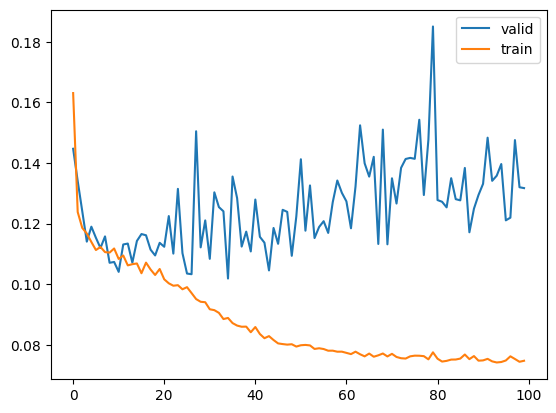

In [45]:
plt.plot(history2.history["val_loss"])
plt.plot(history2.history["loss"])
plt.legend(["valid", "train"])
plt.show()

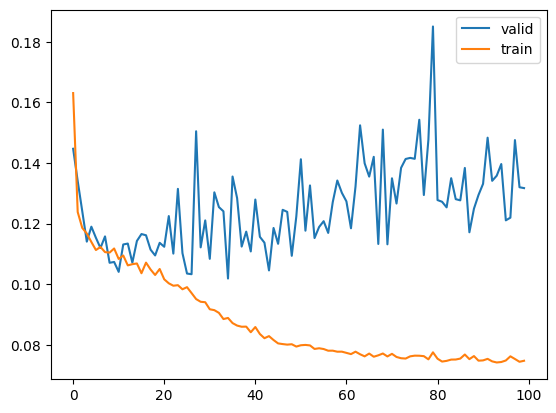

In [46]:
plt.plot(history2.history["val_loss"])
plt.plot(history2.history["loss"])
plt.legend(["valid", "train"])
plt.show()

In [47]:
y_pred2 = model2.predict(x_test)

7/7 [==============================] - 0s 35ms/step


In [48]:
print(f"mean absolute error is {mean_absolute_error(y_pred2, y_test)}")

mean absolute error is 0.023379506086084648


In [49]:
def model1_predictions(img_number):
  model1_prediction = model1.predict(x_test[img_number].reshape(1, 128, 128, 1))
  model1_prediction = model1_prediction[0]
  img = x_test[img_number]

  count = 0
  bbox1 = []
  for i in model1_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 17ms/step


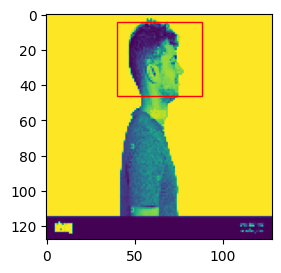

In [50]:
model1_predictions(10)

In [51]:
def model2_predictions(img_number):
  model2_prediction = model2.predict(x_test[img_number].reshape(1, 128, 128, 1))
  model2_prediction = model2_prediction[0]
  img = x_test[img_number]

  count = 0
  bbox1 = []
  for i in model2_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 18ms/step


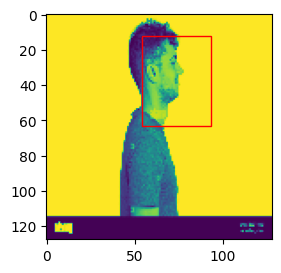

In [52]:
model2_predictions(10)

In [53]:
uploaded = files.upload()

Saving homen_negro.png to homen_negro.png


In [55]:
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(128,128))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
img_name= 'homen_negro.png'

In [74]:
images_mid = []
for img_name_mid in uploaded.keys():
    for itr in uploaded:
      if img_name_mid==img_name:
        img_arr_mid = cv.imread(img_name_mid, cv.IMREAD_GRAYSCALE)
        resized_img_mid = cv.resize(img_arr_mid, (128, 128))
        images_mid.append(resized_img_mid)
        print(images_mid)

[array([[ 10,   9,   9, ..., 110, 112, 108],
       [  9,   9,   9, ..., 106,  83,  68],
       [ 32,   7,  10, ...,  90,  95,  93],
       ...,
       [ 23,  25,  27, ...,  62,  49,  69],
       [ 11,  12,  23, ...,  56,  57,  36],
       [ 11,  10,  10, ...,  45,  53,  58]], dtype=uint8)]


In [83]:
def model2_predictions_mid(img):
  model2_prediction = model2.predict(images_mid[img].reshape(1, 128, 128, 1))
  model2_prediction = model2_prediction[0]
  img = images_mid[img]

  count = 0
  bbox1 = []
  for i in model2_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 18ms/step


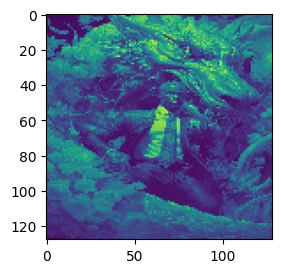

In [84]:
model2_predictions_mid(0)

In [81]:
def model1_predictions(img_number):
  model1_prediction = model1.predict(images_mid[img_number].reshape(1, 128, 128, 1))
  model1_prediction = model1_prediction[0]
  img = images_mid[img_number]

  count = 0
  bbox1 = []
  for i in model1_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 18ms/step


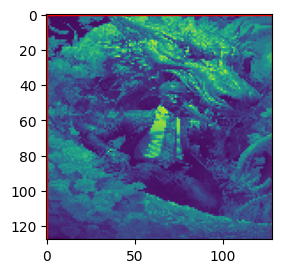

In [82]:
model1_predictions(0)

In [85]:
guesha_upload = files.upload()

Saving guesha_1.png to guesha_1.png


In [88]:
img_path = list(guesha_upload.keys())[0]
img_guesha = image.load_img(img_path, target_size=(128,128))
img_guesha = image.img_to_array(img_guesha)
img_guesha = np.expand_dims(img_guesha, axis=0)
img_guesha = preprocess_input(img_guesha)
img_name_guesha = 'guesha_1.png'

In [93]:
images_mid_guesha = []
for img_name_mid_guesha in guesha_upload.keys():
    for itr in guesha_upload:
      if img_name_mid_guesha==img_name_guesha:
        img_arr_mid_guesha = cv.imread(img_name_mid_guesha, cv.IMREAD_GRAYSCALE)
        resized_img_mid_guesha = cv.resize(img_arr_mid_guesha, (128, 128))
        images_mid_guesha.append(resized_img_mid_guesha)
        print(images_mid_guesha)

[array([[27, 28, 29, ..., 64, 64, 62],
       [29, 31, 34, ..., 70, 70, 68],
       [31, 33, 39, ..., 79, 75, 68],
       ...,
       [ 2,  2,  2, ..., 38, 35, 33],
       [ 2,  2,  2, ..., 41, 39, 36],
       [ 2,  2,  2, ..., 47, 43, 40]], dtype=uint8)]


In [94]:
images_mid_guesha[0]

array([[27, 28, 29, ..., 64, 64, 62],
       [29, 31, 34, ..., 70, 70, 68],
       [31, 33, 39, ..., 79, 75, 68],
       ...,
       [ 2,  2,  2, ..., 38, 35, 33],
       [ 2,  2,  2, ..., 41, 39, 36],
       [ 2,  2,  2, ..., 47, 43, 40]], dtype=uint8)

In [90]:
def model1_predictions_guesha(img_number):
  model1_prediction = model1.predict(images_mid_guesha[img_number].reshape(1, 128, 128, 1))
  model1_prediction = model1_prediction[0]
  img = images_mid_guesha[img_number]

  count = 0
  bbox1 = []
  for i in model1_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 18ms/step


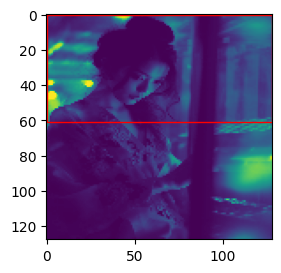

In [95]:
model1_predictions_guesha(0)

In [97]:
def model2_predictions_mid_guesha(img):
  model2_prediction = model2.predict(images_mid_guesha[img].reshape(1, 128, 128, 1))
  model2_prediction = model2_prediction[0]
  img = images_mid_guesha[img]

  count = 0
  bbox1 = []
  for i in model2_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 19ms/step


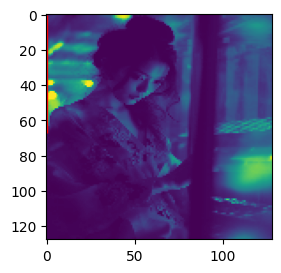

In [98]:
model2_predictions_mid_guesha(0)

In [99]:
escultura = files.upload()

Saving escultura.png to escultura.png


In [101]:
img_path = list(escultura.keys())[0]
img_escultura = image.load_img(img_path, target_size=(128,128))
img_escultura = image.img_to_array(img_escultura)
img_escultura = np.expand_dims(img_escultura, axis=0)
img_escultura = preprocess_input(img_escultura)
img_name_escultura = 'escultura.png'

In [102]:
images_mid_escultura = []
for img_name_mid_escultura in escultura.keys():
    for itr in escultura:
      if img_name_mid_escultura==img_name_escultura:
        img_arr_mid_escultura = cv.imread(img_name_mid_escultura, cv.IMREAD_GRAYSCALE)
        resized_img_mid_escultura = cv.resize(img_arr_mid_escultura, (128, 128))
        images_mid_escultura.append(resized_img_mid_escultura)
        print(images_mid_escultura)

[array([[53, 53, 53, ..., 55, 55, 54],
       [54, 55, 55, ..., 57, 57, 56],
       [56, 56, 56, ..., 60, 59, 59],
       ...,
       [53, 55, 54, ..., 52, 52, 53],
       [50, 55, 51, ..., 51, 50, 52],
       [47, 49, 49, ..., 48, 50, 46]], dtype=uint8)]


In [103]:
images_mid_escultura[0]

array([[53, 53, 53, ..., 55, 55, 54],
       [54, 55, 55, ..., 57, 57, 56],
       [56, 56, 56, ..., 60, 59, 59],
       ...,
       [53, 55, 54, ..., 52, 52, 53],
       [50, 55, 51, ..., 51, 50, 52],
       [47, 49, 49, ..., 48, 50, 46]], dtype=uint8)

In [105]:
def model1_predictions_escultura(img_number):
  model1_prediction = model1.predict(images_mid_escultura[img_number].reshape(1, 128, 128, 1))
  model1_prediction = model1_prediction[0]
  img = images_mid_escultura[img_number]

  count = 0
  bbox1 = []
  for i in model1_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 19ms/step


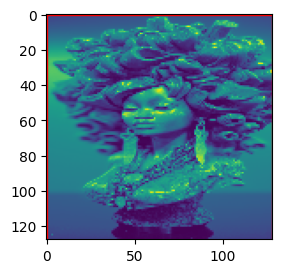

In [107]:
model1_predictions_escultura(0)

In [110]:
def model2_predictions_mid_escultura(img):
  model2_prediction = model2.predict(images_mid_escultura[img].reshape(1, 128, 128, 1))
  model2_prediction = model2_prediction[0]
  img = images_mid_escultura[img]

  count = 0
  bbox1 = []
  for i in model2_prediction:
    bbox1.append(i)
    count+=1
    if count==4:
      count = 0
      plt.subplot(1,2,1)
      plt.imshow(img)
      x1 = int(bbox1[0]*128)
      y1 = int(bbox1[1]*128)
      x2 = int(bbox1[2]*128)
      y2 = int(bbox1[3]*128)
      plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1,edgecolor='r', facecolor="none"))
      bbox1 = []
  plt.show()

1/1 [==============================] - 0s 20ms/step


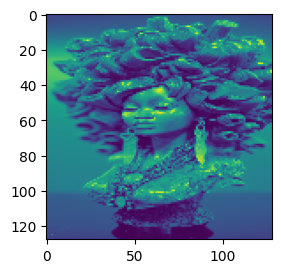

In [111]:
model2_predictions_mid_escultura(0)